In [0]:
import pandas as pd
import xgboost as xgb
import mlflow
import pyspark.pandas as ps
from hyperopt.pyll import scope
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, SparkTrials

In [0]:
df = ps.read_csv("/dbfs/FileStore/dfprocessed.csv", header='infer')

In [0]:
df = df.to_pandas()

In [0]:
df.head()

,A2,A3,A8,A14,A15,A1_encoded,A4_encoded,A5_encoded,A6_encoded,A7_encoded,A9_encoded,A10_encoded,A11_encoded,A12_encoded,A13_encoded,class
0,30.83,0.000,1.25,202.0,0,0,0,0,2,0,0,1,1,0,0,1
1,58.67,4.460,3.04,43.0,560,1,0,0,1,1,0,1,4,0,0,1
2,24.50,0.500,1.50,280.0,824,1,0,0,1,1,0,0,0,0,0,1
3,27.83,1.540,3.75,100.0,3,0,0,0,2,0,0,1,6,1,0,1
4,20.17,5.625,1.71,120.0,0,0,0,0,2,0,0,0,0,0,1,1


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A2           690 non-null    float64
 1   A3           690 non-null    float64
 2   A8           690 non-null    float64
 3   A14          690 non-null    float64
 4   A15          690 non-null    int32  
 5   A1_encoded   690 non-null    int32  
 6   A4_encoded   690 non-null    int32  
 7   A5_encoded   690 non-null    int32  
 8   A6_encoded   690 non-null    int32  
 9   A7_encoded   690 non-null    int32  
 10  A9_encoded   690 non-null    int32  
 11  A10_encoded  690 non-null    int32  
 12  A11_encoded  690 non-null    int32  
 13  A12_encoded  690 non-null    int32  
 14  A13_encoded  690 non-null    int32  
 15  class        690 non-null    int32  
dtypes: float64(4), int32(12)
memory usage: 59.3 KB


In [0]:
# Define train set size
train_size = int(0.7 * len(df))

In [0]:
# Split dataset 
train = df[:train_size]
test = df[train_size:]

In [0]:
# Convert data to the optimized data structure DMatrix
dtrain = xgb.DMatrix(train[['A2', 'A3', 'A8', 'A14', 'A15', 'A1_encoded', 'A4_encoded', 'A5_encoded', 'A6_encoded', 'A7_encoded', 'A9_encoded', 'A10_encoded', 'A11_encoded', 'A12_encoded', 'A13_encoded']], label=train["class"])
dtest = xgb.DMatrix(test[['A2', 'A3', 'A8', 'A14', 'A15', 'A1_encoded', 'A4_encoded', 'A5_encoded', 'A6_encoded', 'A7_encoded', 'A9_encoded', 'A10_encoded', 'A11_encoded', 'A12_encoded', 'A13_encoded']], label=test["class"])

In [0]:
# Define the objective function that Hyperopt will optimize.
def train_xgb(params):
    mlflow.xgboost.autolog(silent=True) 
    with mlflow.start_run(nested=True):
                             
                                 
                                   
            model = xgb.train(params=params, dtrain=dtrain, num_boost_round=500, evals=[(dtest, "test")],                                             verbose_eval=False)

            predictions = model.predict(dtest)
            
            auc_score = roc_auc_score(test['class'], predictions)
                      
            mlflow.log_metric("auc_score", auc_score)

 

    return {'status': STATUS_OK, 'loss': -auc_score}

In [0]:
# Hyperparameters search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 50)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'alpha': hp.loguniform('alpha', -10, 10),
    'lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
}

In [0]:
# Execute search using fmi
with mlflow.start_run(run_name='initial_search'):
    best_params = fmin(
      fn=train_xgb,
      space=space,
      algo=tpe.suggest,
      max_evals=20,
      #rstate=np.random.RandomState(123),
      # trials=spark_trials
    )

100%|██████████| 20/20 [01:34<00:00,  4.70s/trial, best loss: -0.9334274952919022]


In [0]:
best_params

Out[31]: {'alpha': 0.4197135997100693,
 'colsample_bytree': 0.5155667954438115,
 'gamma': 0.10617399074268867,
 'lambda': 0.024402513266066045,
 'learning_rate': 0.0023298729879080325,
 'max_depth': 33.155055684623356,
 'min_child_weight': 0.27770312245307754,
 'subsample': 0.522352483148095}

Parallel coordinates maxdepth, learning rate, etc
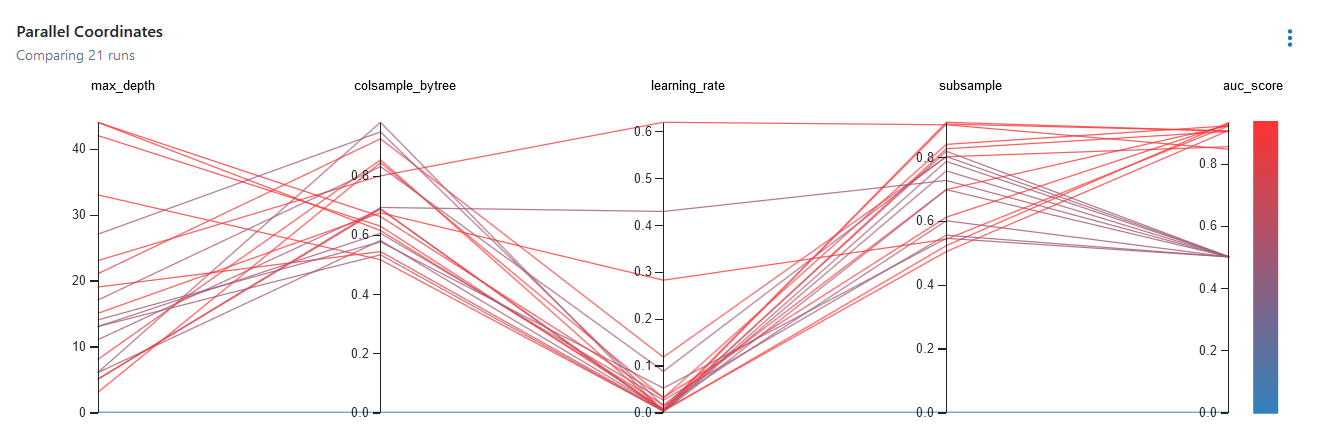

Regularization hyperparameters
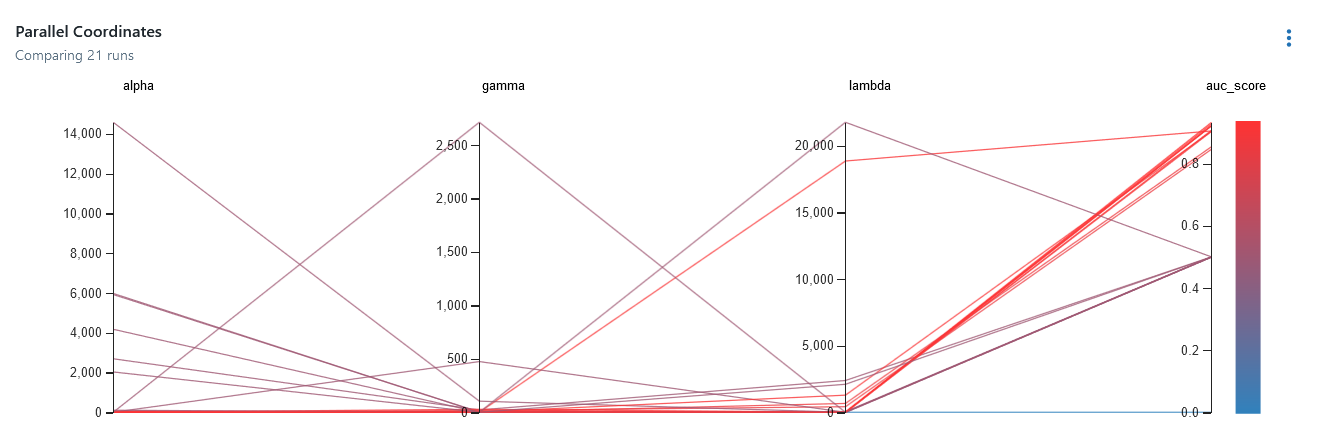

Ten first runs
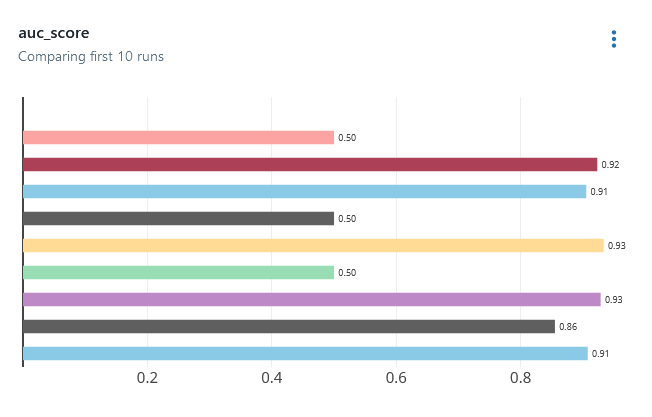

Learning rate - scatter chart
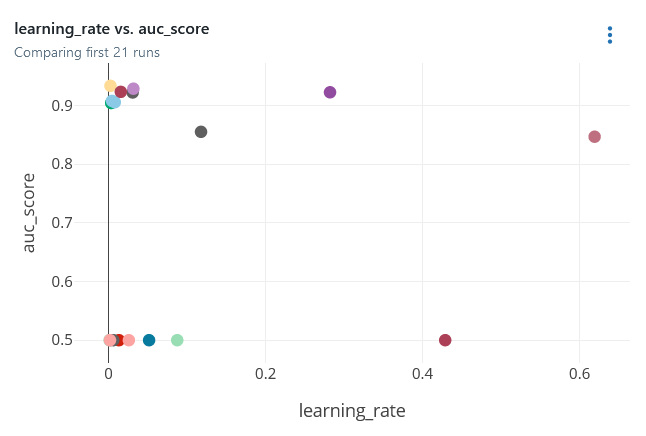